<a href="https://colab.research.google.com/github/abelowska/mlNeuro/blob/main/2025/MLN_p3_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple P300 Speller

Detect when participant see target, and when non-target stimuli using [BI2015a dataset](https://neurotechx.github.io/moabb/generated/moabb.datasets.BI2015a.html#moabb.datasets.BI2015a).

In [ ]:
!pip install moabb
!pip install mne

Imports

In [ ]:
import moabb
import mne
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Prepare data

### 1. Fetch data

In [ ]:
# Get data fro one subject. It might take a while
dataset = moabb.datasets.BI2015a()
data = dataset.get_data(subjects=[1])

In [ ]:
data[]

{1: {'0': {'0': <RawArray | 33 x 614400 (1200.0 s), ~154.7 MiB, data loaded>},
  '1': {'0': <RawArray | 33 x 404672 (790.4 s), ~101.9 MiB, data loaded>},
  '2': {'0': <RawArray | 33 x 184128 (359.6 s), ~46.4 MiB, data loaded>}}}

Extract `MNE` `Raw` from the downloaded data

In [ ]:
subject = 1
session = '0'
run = '0'

raw = data[subject][session][run]
raw

<RawArray | 33 x 614400 (1200.0 s), ~154.7 MiB, data loaded>

### 2. Simple Raw pre-processing

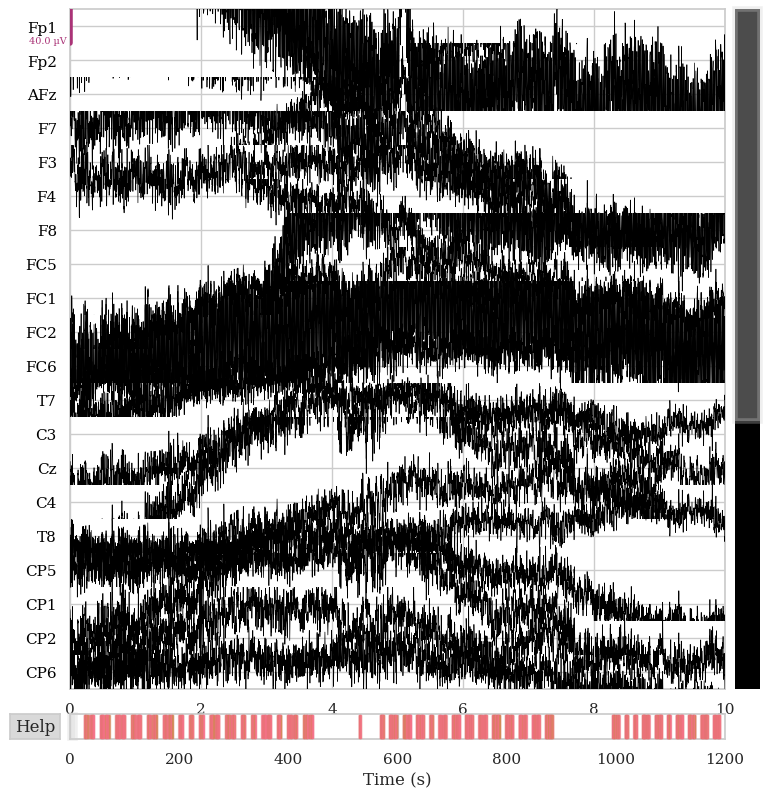

Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 30.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done  23 out of  32 | elapsed:    2.2s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  30 out of  32 | elapsed:    2.4s remaining:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=10)]: Done  32 out of  32 | elapsed:    2.4s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done  30 out of  32 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=10)]: Done  32 out of  32 | elapsed:    2.5s finished


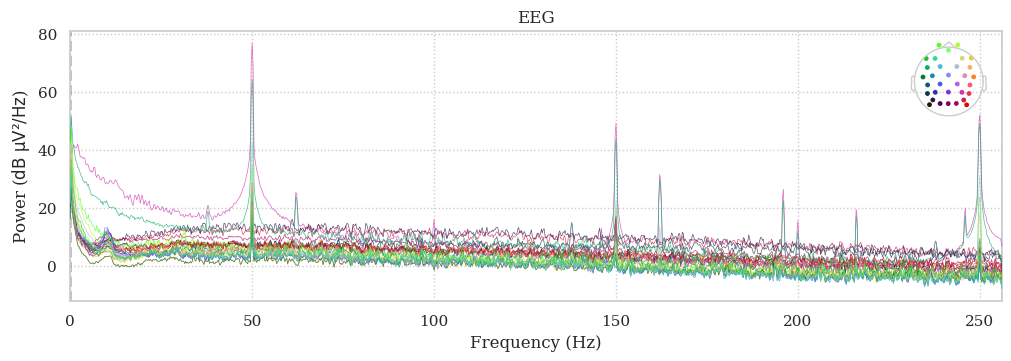

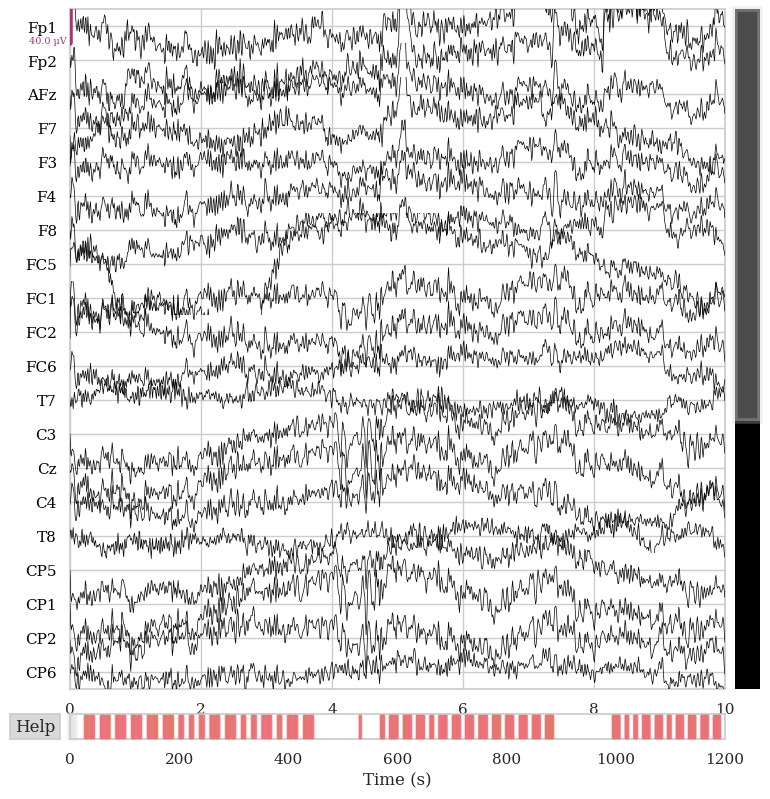

Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).


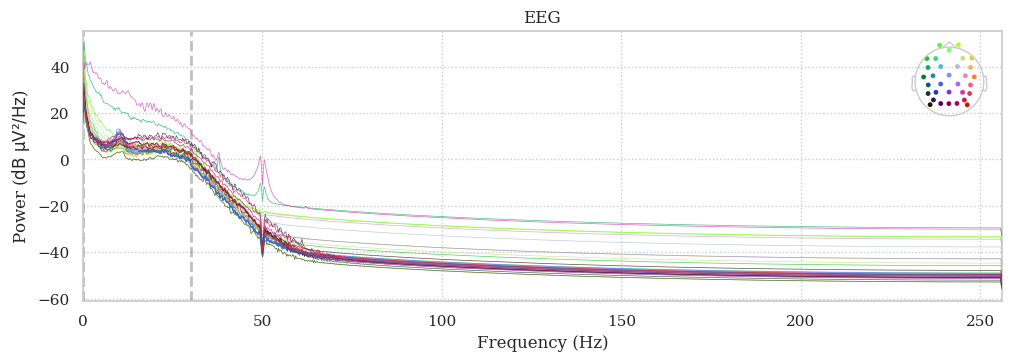

In [ ]:
fig = raw.plot()
fig = raw.compute_psd().plot()
# 1. re-reference: to almost-mastoids
raw.set_eeg_reference(ref_channels=['T7', 'T8'])

# 2. band-pass filter
raw_filtered = raw.copy().filter(
    picks=['eeg'],
    l_freq=.1,
    h_freq=30.0,
    n_jobs=10,
    method='iir',
    iir_params=None
    )

# 3. Notch filter
power_freq = 50
nyquist_freq = raw_filtered.info['sfreq'] / 2

raw_filtered = raw_filtered.notch_filter(
    picks=['eeg', 'eog'],
    freqs=np.arange(power_freq, nyquist_freq, power_freq),
    n_jobs=10,
)

fig = raw_filtered.plot()
fig = raw_filtered.compute_psd().plot()

### 3. Create segments around stimuli

In [ ]:
# fing events on the STIM channel
events = mne.find_events(raw_filtered)

# create events dict
event_ids = {'Target': 2, 'Non-Target': 1}

# create segments
tmin = -0.2
tmax = 0.6
baseline = (-0.2,0)
epochs = mne.Epochs(
    raw_filtered,
    events,
    event_id=event_ids,
    tmin=tmin,
    tmax=tmax,
    baseline=baseline,
)

epochs

2574 events found on stim channel STI 014
Event IDs: [1 2]
Not setting metadata
2574 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


<Epochs | 2574 events (good & bad), -0.199 – 0.6 s (baseline -0.2 – 0 s), ~43 KiB, data not loaded,
 'Target': 429
 'Non-Target': 2145>

### 4. Look into EEG signal for target and non-target stimuli

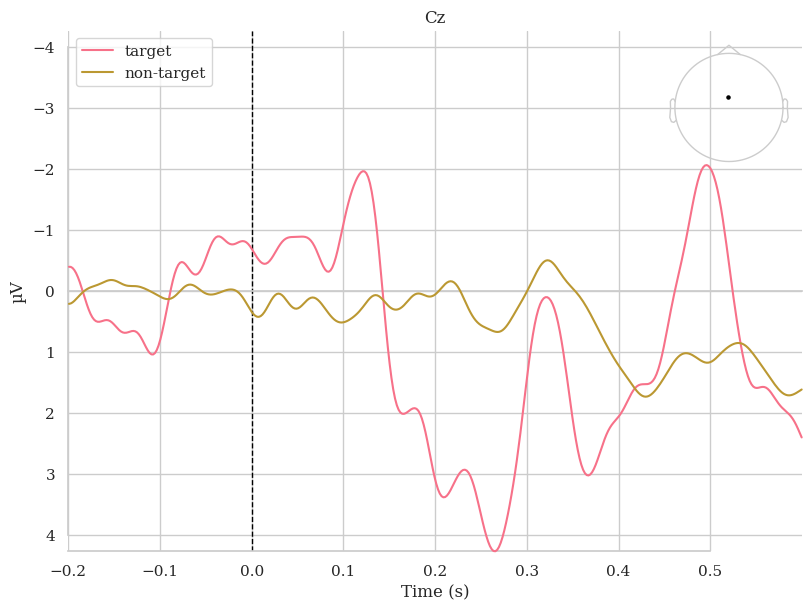

In [ ]:
# create ERPs
target_erp = epochs['Target'].average()
nontarget_erp = epochs['Non-Target'].average()

# compare target and non-target ERPs
picks = ['Cz']

fig = mne.viz.plot_compare_evokeds(
    evokeds = {'target': target_erp, 'non-target': nontarget_erp},
    picks=picks,
    invert_y=True
)

## ML model

Now you can use your `epochs` to create a model

In [ ]:
X_train = epochs.get_data(picks='Cz')
y_train = epochs.events[:,-1]

# Create LDA model
lda = LinearDiscriminantAnalysis()

# Reshape data if necessary (LDA expects 2D input: [samples, features])
X_train_lda = X_train.reshape(X_train.shape[0], -1)  # Flatten EEG data

# Train the model
lda.fit(X_train_lda, y_train)

# Make predictions
y_pred = lda.predict(X_train_lda)

# Evaluate the model
accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_train, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_train, y_pred))

Using data from preloaded Raw for 2574 events and 410 original time points ...
Accuracy: 0.8388

Classification Report:
              precision    recall  f1-score   support

           1       0.85      0.98      0.91      2145
           2       0.59      0.11      0.18       429

    accuracy                           0.84      2574
   macro avg       0.72      0.55      0.55      2574
weighted avg       0.80      0.84      0.79      2574


Confusion Matrix:
[[2112   33]
 [ 382   47]]


## Test your model

In [ ]:
def get_test_data(session='1'):
  subject = 1
  session = session
  run = '0'

  test_raw = data[subject][session][run]
  # 1. re-reference: to almost-mastoids
  test_raw.set_eeg_reference(ref_channels=['T7', 'T8'])

  # 2. band-pass filter
  test_raw_filtered = test_raw.copy().filter(
      picks=['eeg'],
      l_freq=.1,
      h_freq=30.0,
      n_jobs=10,
      method='iir',
      iir_params=None
      )

  # 3. Notch filter
  power_freq = 50
  nyquist_freq = test_raw_filtered.info['sfreq'] / 2

  test_raw_filtered = test_raw_filtered.notch_filter(
      picks=['eeg', 'eog'],
      freqs=np.arange(power_freq, nyquist_freq, power_freq),
      n_jobs=10,
  )

  # fing events on the STIM channel
  events = mne.find_events(test_raw_filtered)

  # create events dict
  event_ids = {'Target': 2, 'Non-Target': 1}

  # create segments
  tmin = -0.2
  tmax = 0.6
  baseline = (-0.2,0)
  test_epochs = mne.Epochs(
      test_raw_filtered,
      events,
      event_id=event_ids,
      tmin=tmin,
      tmax=tmax,
      baseline=baseline,
  )

  return test_epochs


def test_checker(X_test, y_test, model, n_samples=10):
  for i in range(len(X_test[:n_samples])):
      print(f"Checking test trial {i + 1}...\n")
      time.sleep(1.4)

      # Get the prediction for the current sample
      y_pred = model.predict(X_test[i].reshape(1, -1))

      # Check if the prediction is correct
      if y_pred[0] == y_test[i]:
          print("Correct! ❤️\n\n")
      else:
          print("Incorrect! 😢\n\n")

      time.sleep(0.5)

In [ ]:
test_epochs = get_test_data(session='1')

Transform your data in exaclty the same way as training data, to facilitate testing procedure:

In [ ]:
X_test = test_epochs.get_data(picks='Cz')
X_test = X_test.reshape(X_test.shape[0], -1)

y_test = test_epochs.events[:,-1]

Using data from preloaded Raw for 1659 events and 410 original time points ...
0 bad epochs dropped


And run `test_checker()` !

In [ ]:
test_checker(X_test=X_test, y_test=y_test, model=lda)

Checking test trial 1...

Correct! ❤️


Checking test trial 2...

Correct! ❤️


Checking test trial 3...

Incorrect! 😢


Checking test trial 4...

Correct! ❤️


Checking test trial 5...

Correct! ❤️


Checking test trial 6...

Correct! ❤️


Checking test trial 7...

Correct! ❤️


Checking test trial 8...

Correct! ❤️


Checking test trial 9...

Correct! ❤️


Checking test trial 10...

Correct! ❤️


